In [6]:
from matplotlib import *
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from scipy.stats import linregress, spearmanr, chi2


Documentation: https://scikit-mobility.github.io/scikit-mobility/

In [ ]:
#pip install scikit-mobility

In [ ]:
import skmob
from skmob.utils import utils, constants
import geopandas as gpd
from skmob.models.epr import DensityEPR

## get the data

(-80.16166435, -71.37824465, 40.250475699999996, 45.2427883)

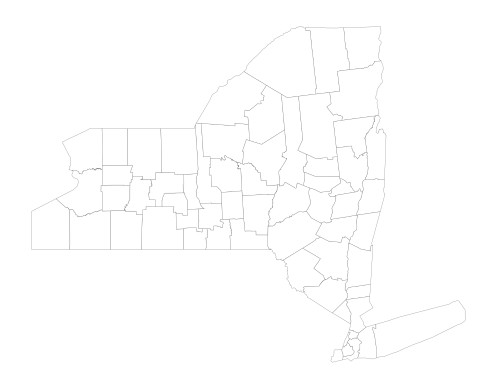

In [7]:
url = skmob.utils.constants.NY_COUNTIES_2011
tessellation = gpd.read_file(url).rename(columns={'tile_id': 'tile_ID'})

tessellation.plot(facecolor='w',edgecolor='grey', lw=0.2)
plt.axis('off')

In [10]:
# load data about mobility flows into a FlowDataFrame
fdf = skmob.FlowDataFrame.from_file(skmob.utils.constants.NY_FLOWS_2011,
                                        tessellation=tessellation,
                                        tile_id='tile_ID',
                                        sep=",")

print(fdf.head())

     flow origin destination
0  121606  36001       36001
1       5  36001       36005
2      29  36001       36007
3      11  36001       36017
4      30  36001       36019


### plot the empirical flows

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_42636/408420153.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tessellation['center'] = tessellation.centroid


(-79.7415509941798, -72.34911145383438, 40.353280021614474, 44.955156292735786)

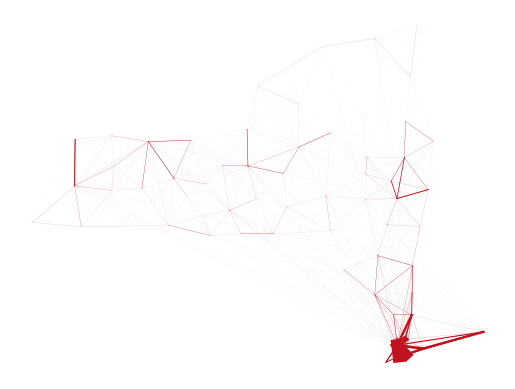

In [11]:
tessellation['center'] = tessellation.centroid
points = dict(zip(tessellation.tile_ID,tessellation.center))


for line in fdf.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 50000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    plt.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    
plt.axis('off')

## Build the Gravity model

The number of trips occurring from i to j are inversely proportional to the distance that divides i and j and where masses of origin and destination are the respective populations.


The form with the power law deterrence functions is written as:  
$\Large T_{ij} = K \frac{m_i^\alpha m_j^\beta}{d^\gamma}$

The form with the exponential deterrence functions is written as:  
$\Large T_{ij} = K m_i^\alpha m_j^\beta e^{-d/d_0}$


where $\alpha$ and $\beta$ modulate the attractiveness of masses  
$\gamma$ regulates the decay of the gravity force with distance  
and $d_0$ represents the typical distance travelled by individuals

In [12]:
from skmob.models import gravity

#build the centroids dictionary
tessellation = gpd.read_file(url).rename(columns={'tile_id': 'tile_ID'})

# compute the total outflows from each location of the tessellation (excluding self loops)
tot_outflows = fdf.groupby(by='origin', axis=0)[['flow']].sum().fillna(0)

tessellation = tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': constants.TOT_OUTFLOW})

# instantiate a singly constrained Gravity model
gravity_singly = gravity.Gravity(gravity_type='singly constrained')

# instantiate a globally constrained Gravity model
gravity_doubly = gravity.Gravity(gravity_type='globally constrained')

print(gravity_singly)


Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


### fit gravity model with exponential deterrence function

In [13]:
# fit the parameters of the Gravity model from real fluxes
gravity_fit_exp = gravity.Gravity(gravity_type='globally constrained',deterrence_func_type="exponential")
print(gravity_fit_exp)
gravity_fit_exp.fit(fdf, relevance_column='population')

# generate synthetic data with the fitted model
synth_fdf_exp = gravity_fit_exp.generate(tessellation,
                                        tile_id_column='tile_ID',
                                        tot_outflows_column='tot_outflow',
                                        relevance_column= 'population',
                                        out_format='flows')
print(synth_fdf_exp.head())


Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 27227.19it/s]

  origin destination      flow
0  36019       36101  0.051474
1  36019       36107  0.151560
2  36019       36059  0.090550
3  36019       36011  1.103398
4  36019       36123  0.079042


In [14]:
### check the fitted params
print(gravity_fit_exp)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[0.030749731677418596], origin_exp=0.46524224820794124, destination_exp=0.6880143486855734, gravity_type="globally constrained")


### fit gravity model with power law deterrence function

In [15]:
# fit the parameters of the Gravity model from real fluxes
gravity_fit_pow = gravity.Gravity(gravity_type='globally constrained',deterrence_func_type="power law")
print(gravity_fit_pow)
gravity_fit_pow.fit(fdf, relevance_column='population')

# generate synthetic data with the fitted model
synth_fdf_pow = gravity_fit_pow.generate(tessellation,
                                        tile_id_column='tile_ID',
                                        tot_outflows_column='tot_outflow',
                                        relevance_column= 'population',
                                        out_format='flows')
print(synth_fdf_pow.head())


Deterrence function type "power law" not available. Power law will be used.
Available deterrence functions are [power_law, exponential]
Gravity(name="Gravity model", deterrence_func_type="power law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 27287.18it/s]

  origin destination        flow
0  36019       36101   84.904420
1  36019       36107   71.191190
2  36019       36059  329.103645
3  36019       36011  120.012269
4  36019       36123   46.571824



/Users/mattiamazzoli/anaconda3/lib/python3.10/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [16]:
### check the fitted params
print(gravity_fit_pow)

Gravity(name="Gravity model", deterrence_func_type="power law", deterrence_func_args=[-1.5867093772379701], origin_exp=0.40496356634063174, destination_exp=0.57650700135857, gravity_type="globally constrained")


### plot the  fitted gravity model flows

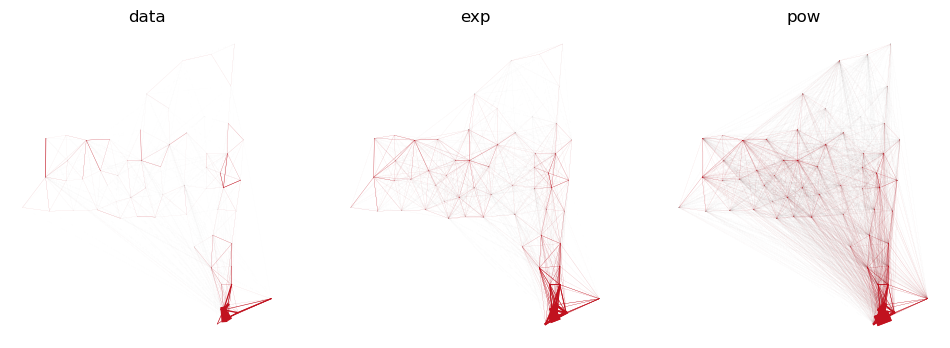

In [17]:
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
ax=axes.flat[0]
for line in fdf.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('data')
    ax.axis('off')
    
ax=axes.flat[1]
for line in synth_fdf_exp.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('exp')
    ax.axis('off')

ax=axes.flat[2]
for line in synth_fdf_pow.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('pow')
    ax.axis('off')


In [18]:
#fill missing routes from the original dataset, set them to 0
places = set(fdf.origin.unique()).union(fdf.destination.unique())

missing_flows = []
for ori in places:
    for dest in places:
        if ((fdf['origin'] == ori) & (fdf['destination'] == dest)).any() == False:
            missing_flows.append([0,ori,dest])

#remove internal mobility
fdf_base = fdf[fdf.origin!=fdf.destination]
synth_fdf_exp = synth_fdf_exp[synth_fdf_exp.origin!=synth_fdf_exp.destination]
synth_fdf_pow = synth_fdf_pow[synth_fdf_pow.origin!=synth_fdf_pow.destination]

#add missing routes to original dataset for comparison
nr = pd.DataFrame(missing_flows,columns=['flow', 'origin', 'destination'])
fdf_new = pd.concat([fdf_base, nr])


In [19]:
#set same order to compare values
fdf_new = pd.DataFrame(fdf_new.sort_values(by=['origin','destination']))
synth_fdf_exp = synth_fdf_exp.sort_values(by=['origin','destination'])
synth_fdf_pow = synth_fdf_pow.sort_values(by=['origin','destination'])

In [20]:
len(fdf_new.flow),len(synth_fdf_exp.flow)

(3782, 3782)

### model selection

In [21]:
from skmob.measures import evaluation

print('pow',skmob.measures.evaluation.common_part_of_commuters(fdf_new.flow.values, synth_fdf_pow.flow.values))
print('exp',skmob.measures.evaluation.common_part_of_commuters(fdf_new.flow.values, synth_fdf_exp.flow.values))

pow 0.39238328374545656
exp 0.4157866966287236


In [22]:
#pearson correlation
print('pow',linregress(fdf_new.flow.values, synth_fdf_pow.flow.values).rvalue)
print('exp',linregress(fdf_new.flow.values, synth_fdf_exp.flow.values).rvalue)


pow 0.5382569813718703
exp 0.5998501153215378


0.5998501153215378


Text(0, 0.5, 'gravity model exp')

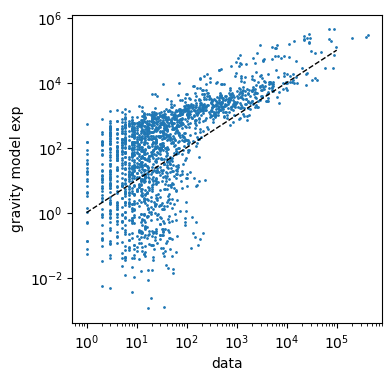

In [23]:
fig,ax=plt.subplots(figsize=(4,4))
print(linregress(fdf_new.flow.values, synth_fdf_exp.flow.values).rvalue)
plt.loglog(fdf_new.flow.values, synth_fdf_exp.flow.values,'o',lw=0,markersize=1)
plt.loglog([1,100000],[1,100000],lw=1,color='k',ls='--')
plt.xlabel('data')
plt.ylabel('gravity model exp')

## Radiation model

In [24]:
from skmob.models import radiation
rad_model = radiation.Radiation()
synth_fdf_rad = rad_model.generate(tessellation,
                                        tile_id_column='tile_ID',
                                        tot_outflows_column='tot_outflow',
                                        relevance_column= 'population',
                                        out_format='flows')
synth_fdf_rad = pd.DataFrame(synth_fdf_rad.sort_values(by=['origin','destination']))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 3657.84it/s]


In [25]:
synth_fdf_rad

,origin,destination,flow
2979,36001,36003,7.0
2955,36001,36005,2171.0
2948,36001,36007,1125.0
2983,36001,36009,11.0
2963,36001,36011,21.0
...,...,...,...
303,36123,36109,254.0
333,36123,36111,2.0
307,36123,36117,58.0
343,36123,36119,4.0


In [26]:
missing_flows = []
for ori in places:
    for dest in places:
        if ((synth_fdf_rad['origin'] == ori) & (synth_fdf_rad['destination'] == dest)).any() == False:
            missing_flows.append([0,ori,dest])

#add missing routes to radiation modelled flows, for comparison
nr = pd.DataFrame(missing_flows,columns=['flow', 'origin', 'destination'])
synth_fdf_new = pd.concat([synth_fdf_rad, nr])
#remove internal mobility
synth_fdf_rad = synth_fdf_new[synth_fdf_new.origin!=synth_fdf_new.destination]

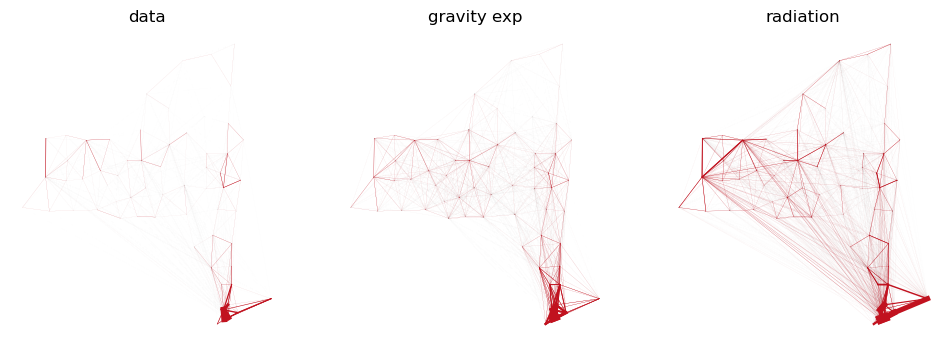

In [27]:
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
ax=axes.flat[0]
for line in fdf.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('data')
    ax.axis('off')
    
ax=axes.flat[1]
for line in synth_fdf_exp.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('gravity exp')
    ax.axis('off')

ax=axes.flat[2]
for line in synth_fdf_rad.iterrows():
    orig = line[1].origin
    dest = line[1].destination
    flow = line[1].flow / 100000
    #print(flow)
    x1 = points[orig].x
    y1 = points[orig].y
    x2 = points[dest].x
    y2 = points[dest].y
    ax.plot([x1,x2],[y1, y2], '#c1121f',linewidth=flow)
    ax.set_title('radiation')
    ax.axis('off')


### model selection

In [28]:
#common part of commuters
print('rad',skmob.measures.evaluation.common_part_of_commuters(fdf_new.flow.values, synth_fdf_rad.flow.values))
print('exp',skmob.measures.evaluation.common_part_of_commuters(fdf_new.flow.values, synth_fdf_exp.flow.values))

rad 0.031276841768704905
exp 0.4157866966287236


In [29]:
#pearson correlation
print('rad',linregress(fdf_new.flow.values, synth_fdf_rad.flow.values).rvalue)
print('exp',linregress(fdf_new.flow.values, synth_fdf_exp.flow.values).rvalue)

rad -0.004043401590820791
exp 0.5998501153215378


Text(0, 0.5, 'radiation model')

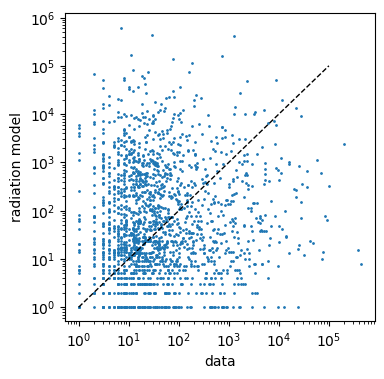

In [30]:
fig,ax=plt.subplots(figsize=(4,4))
plt.loglog(fdf_new.flow.values, synth_fdf_rad.flow.values,'o',lw=0,markersize=1)
plt.loglog([1,100000],[1,100000],lw=1,color='k',ls='--')
plt.xlabel('data')
plt.ylabel('radiation model')